# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, precision_score, accuracy_score, fbeta_score, f1_score

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Load dataset

In [3]:
import glob
path = 'data/final/train/'
all_files = glob.glob(path + '*.csv')
# list to append csvs
l = []
# loop over all files
for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=0)
    l.append(df_tmp)

# Add all data frames together
df = pd.concat(l, axis=0, ignore_index=True)

### Turn result to dummies

In [4]:
# turn result to dummies
d = {'successful': 1, 'failed': 0}
df.state = [d[i] for i in df.state]
y_model = df.state

# Create full dataset
all possible features are:
* blurb/slug (need to be turned to dict dummies)
* category (use engineers trick to turn to one param which is success rate as float)
* currency (as dummy)
* usd_type (as dummy)
* goal_usd
* word_count
* days_running

### Change category to single feature
Change category dummies to single feature

In [5]:
total = df.category.value_counts(sort=False)
success = df.query('state == 1').category.value_counts(sort=False)
category_to_rate = dict(success/total)
df['category_rate'] = [category_to_rate[i] for i in df.category]

In [6]:
X_model = df[['goal_usd', 'word_count', 'days_running', 'category_rate']].copy()

In [7]:
X_model = pd.concat([X_model, pd.get_dummies(df.usd_type, drop_first=True, prefix='usd_type')], axis=1)
X_model = pd.concat([X_model, pd.get_dummies(df.currency, drop_first=True, prefix='currency')], axis=1)

# Train Validation split with all possible features

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_model = scaler.fit_transform(X_model)

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=1, test_size=0.1)

# Benchmark
Use a Naive bias model, to create fast benchmark model!

In [9]:
from sklearn.naive_bayes import GaussianNB

In [10]:
# Create naive bayes instance, fit it to training set
gnb = GaussianNB()
gnb.fit(X_train, y_train);

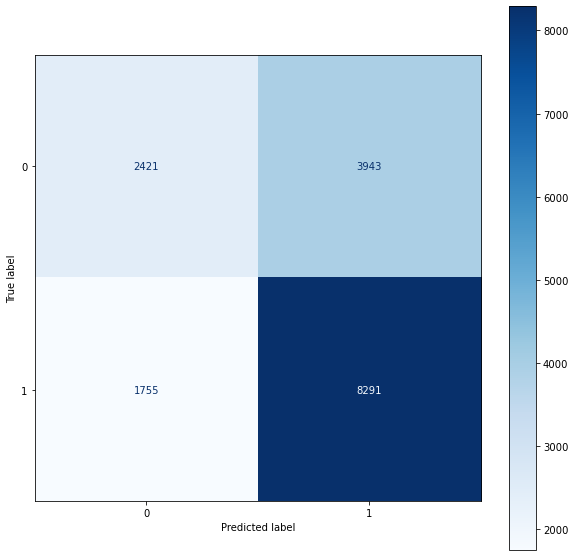

In [11]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(gnb, X_test, y_test,
                             #display_labels=df.state.unique(),
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd',
                             ax=ax)
plt.grid(False)
plt.show()

In [12]:
# print report
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.38      0.46      6364
           1       0.68      0.83      0.74     10046

    accuracy                           0.65     16410
   macro avg       0.63      0.60      0.60     16410
weighted avg       0.64      0.65      0.63     16410



We want to __reduce false positives and false negatives__ to make best predictions. Neither of them is really harming our business more than the other. Therefore best metrics would be accuracy or f1-score. Since __data is little unbalanced__, use __f1-score__.

In [13]:
method_result = pd.DataFrame({'metric': ['accuracy', 'f1-score'],
                          'naive bayes': [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]})
method_result

,metric,naive bayes
0,accuracy,0.65
1,f1-score,0.74


# Feature Importance / Ada boost
Use Ada boost to get feature importances for further analysis.

In [14]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [15]:
X_model = df[['goal_usd', 'word_count', 'days_running', 'category_rate']].copy()

X_model = pd.concat([X_model, pd.get_dummies(df.usd_type, drop_first=True, prefix='usd_type')], axis=1)
X_model = pd.concat([X_model, pd.get_dummies(df.currency, drop_first=True, prefix='currency')], axis=1)

y_model = df.state

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=1, test_size=0.1)

In [16]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier()

adb.fit(X_train, y_train)

importances = adb.feature_importances_

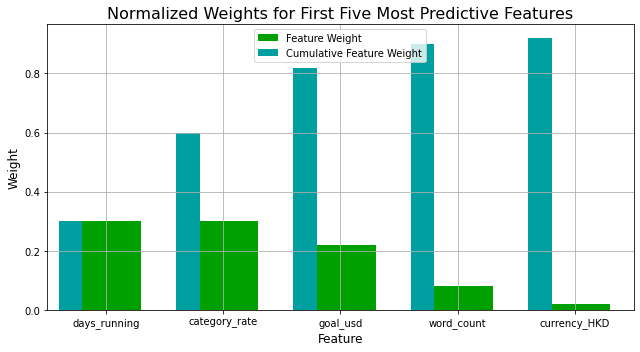

Index(['goal_usd', 'word_count', 'days_running', 'category_rate',
       'usd_type_international', 'currency_CAD', 'currency_CHF',
       'currency_DKK', 'currency_EUR', 'currency_GBP', 'currency_HKD',
       'currency_JPY', 'currency_MXN', 'currency_NOK', 'currency_NZD',
       'currency_SEK', 'currency_SGD', 'currency_USD'],
      dtype='object')

In [17]:
feature_plot(importances, X_train, y_train)
X_train.columns

As expected __usd_type__ has __no influence__ on model. Currency model seems pretty unstable, espacially because of low obs for some currencies! __Remove__ both features!

In [18]:
y_pred = adb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.43      0.52      6364
           1       0.70      0.85      0.77     10046

    accuracy                           0.69     16410
   macro avg       0.67      0.64      0.64     16410
weighted avg       0.68      0.69      0.67     16410



### adb without currency, usd_type

In [19]:
X_model = df[['goal_usd', 'word_count', 'days_running', 'category_rate']].copy()
X_model = scaler.fit_transform(X_model)

y_model = df.state

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=1, test_size=0.1)

In [20]:
adb = AdaBoostClassifier()

adb.fit(X_train, y_train);

In [21]:
y_pred = adb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.43      0.51      6364
           1       0.70      0.85      0.77     10046

    accuracy                           0.68     16410
   macro avg       0.67      0.64      0.64     16410
weighted avg       0.68      0.68      0.67     16410



__No loss__ in any way, __keep__ currency and usd_type __removed__!

In [22]:
# Append new results to model results
method_result['ada_unopt'] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
method_result

,metric,naive bayes,ada_unopt
0,accuracy,0.65,0.68
1,f1-score,0.74,0.77


# Adaboost hyperparameter optimization
Try to get best adaboost model!

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [25]:
# parameters to test
parameters = {'n_estimators': np.linspace(10, 100,3).astype(int),                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.linspace(2, 8, 3).astype(int),               
              'base_estimator__max_depth' : np.linspace(1, 5, 3).astype(int)              
             } 

In [26]:
# Set grid, sore with f1, set low cv because long calculation
grid_adb = GridSearchCV(clf, param_grid=parameters, cv=2, scoring="f1", n_jobs=-1)#scorer)

In [27]:
# Single longest run to estimate runtime
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=0.1)
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print('calculation took {:.2f} m'.format((end-start)/60))

calculation took 0.82 m


In [28]:
start = time.time()
grid_adb.fit(X_train, y_train)
end = time.time()
print('calculation took {:.2f} m'.format((end-start)/60))

calculation took 3.88 m


In [29]:
grid_adb.best_params_

{'base_estimator__max_depth': 5,
 'base_estimator__min_samples_split': 8,
 'learning_rate': 0.1,
 'n_estimators': 55}

Try new grid search with parameters closer to best match!

In [30]:
parameters = {'n_estimators': [40,50,60],                
              'learning_rate':[0.1],               
              'base_estimator__min_samples_split' : [2],               
              'base_estimator__max_depth' : [5,6,7]              
             } 

In [31]:
grid_adb = GridSearchCV(clf, param_grid=parameters, cv=2, scoring="f1", n_jobs=-1)

In [32]:
start = time.time()
grid_adb.fit(X_train, y_train)
end = time.time()
print('calculation took {:.2f} m'.format((end-start)/60))

calculation took 0.92 m


In [33]:
grid_adb.best_params_

{'base_estimator__max_depth': 6,
 'base_estimator__min_samples_split': 2,
 'learning_rate': 0.1,
 'n_estimators': 40}

Take __best model__!

In [34]:
adb = grid_adb.best_estimator_
adb.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.1, n_estimators=40)

### Evaluation

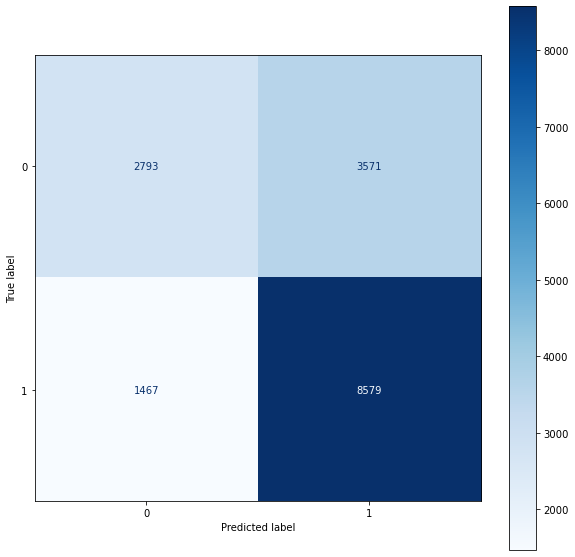

              precision    recall  f1-score   support

           0       0.66      0.44      0.53      6364
           1       0.71      0.85      0.77     10046

    accuracy                           0.69     16410
   macro avg       0.68      0.65      0.65     16410
weighted avg       0.69      0.69      0.68     16410



In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(adb, X_test, y_test,
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd',
                             ax=ax)
plt.grid(False)
plt.show()
y_pred = adb.predict(X_test)
print(classification_report(y_test, y_pred))

In [36]:
# Append new results to model results
method_result['ada_opt'] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
method_result

,metric,naive bayes,ada_unopt,ada_opt
0,accuracy,0.65,0.68,0.69
1,f1-score,0.74,0.77,0.77


Model is __better__ than naive bayes benchmark. But the model has not improved through hyperparameter optimization.

# Decision Tree
Try a simple Decision tree, see if it is really worse ada boost

In [37]:
# test simple decision tree
dtree = DecisionTreeClassifier(class_weight='balanced')
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [38]:
# Append new results to model results
method_result['dec_tree_unopt'] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
method_result

,metric,naive bayes,ada_unopt,ada_opt,dec_tree_unopt
0,accuracy,0.65,0.68,0.69,0.66
1,f1-score,0.74,0.77,0.77,0.72


### Optimize hyperparameters of Decision tree

In [39]:
# set class weight balanced due to slightly unbalanced data set
clf = DecisionTreeClassifier(class_weight='balanced')

# parameters to test
parameters = {'criterion': ["gini", "entropy"],                
              'splitter': ["best", "random"],               
              'min_samples_split' : np.linspace(2, 20, 4).astype(int),               
              'max_depth' : np.linspace(1, 9, 4).astype(int),
              'max_leaf_nodes': [None, 10, 100, 500, 1000]
             } 

In [40]:
grid_dtree = GridSearchCV(clf, param_grid=parameters, cv=5,  scoring="f1", n_jobs=-1)#scorer)

In [41]:
# Single longest run to estimate runtime
clf = DecisionTreeClassifier(class_weight='balanced')
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print('calculation took {:.2f} m'.format((end-start)/60))

calculation took 0.01 m


In [42]:
start = time.time()
grid_dtree.fit(X_train, y_train)
end = time.time()
print('calculation took {:.2f} m'.format((end-start)/60))

calculation took 1.41 m


In [43]:
grid_dtree.best_params_

{'criterion': 'entropy',
 'max_depth': 1,
 'max_leaf_nodes': 1000,
 'min_samples_split': 20,
 'splitter': 'random'}

Do another grid search around best parameters.

In [44]:
# parameters to fit
parameters = {'criterion': ["entropy"],                
              'splitter': ["best"],               
              'min_samples_split' : np.linspace(20, 50, 4).astype(int),               
              'max_depth' : [5,6,7],
              'max_leaf_nodes': [None]
             } 

In [45]:
grid_dtree = GridSearchCV(clf, param_grid=parameters, cv=5,  scoring="f1", n_jobs=-1)

In [46]:
start = time.time()
grid_dtree.fit(X_train, y_train)
end = time.time()
print('calculation took {:.2f} m'.format((end-start)/60))

calculation took 0.10 m


In [47]:
grid_dtree.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_leaf_nodes': None,
 'min_samples_split': 20,
 'splitter': 'best'}

Take __best model__!

In [48]:
dtree = grid_dtree.best_estimator_
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_split=20)

### Evaluation

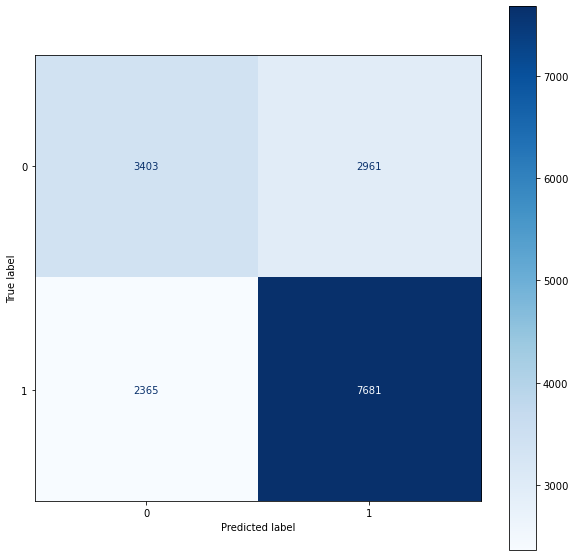

              precision    recall  f1-score   support

           0       0.59      0.53      0.56      6364
           1       0.72      0.76      0.74     10046

    accuracy                           0.68     16410
   macro avg       0.66      0.65      0.65     16410
weighted avg       0.67      0.68      0.67     16410



In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(dtree, X_test, y_test,
                             #display_labels=df.state.unique(),
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd',
                             ax=ax)
plt.grid(False)
plt.show()
y_pred = dtree.predict(X_test)
print(classification_report(y_test, y_pred))

In [50]:
# Append new results to model results
method_result['dec_tree_opt'] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
method_result

,metric,naive bayes,ada_unopt,ada_opt,dec_tree_unopt,dec_tree_opt
0,accuracy,0.65,0.68,0.69,0.66,0.68
1,f1-score,0.74,0.77,0.77,0.72,0.74


Model is as good as ada boost, and much faster, no need to take more expensive model!

### modelling KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, mean_squared_error, classification_report

In [52]:
# knn-classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [53]:
# Make prediction
y_pred = knn.predict(X_test)

##### Printing the results

[[3028 3336]
 [2240 7806]]
Recall: 0.66
Precision: 0.65
F1-Score: 0.65
Accuracy: 0.66


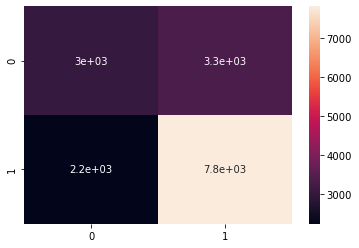

In [54]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True);
print("Recall: " + str(round(recall_score(y_test, y_pred, average = "weighted"),2)))
print("Precision: " + str(round(precision_score(y_test, y_pred, average = "weighted"),2)))
print("F1-Score: " + str(round(f1_score(y_test, y_pred, average = "weighted"),2)))
print("Accuracy: " + str(round(accuracy_score(y_test, y_pred),2)))
# print("Mean Squared Error: " + str(round(mean_squared_error_score(y_test, y_pred),2)))

##### Testing (from when) how many (k) nearest neighbors gives best accuracy

In [55]:
accuracy_lst = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors = k, metric='euclidean')
    knn.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, knn.predict(X_test))
    accuracy_lst.append(round(accuracy, 3))
print(accuracy_lst)

[0.655, 0.589, 0.642, 0.623, 0.66, 0.646, 0.667, 0.657, 0.667, 0.663, 0.672, 0.666, 0.674, 0.67]


##### k = 13 is a good choice

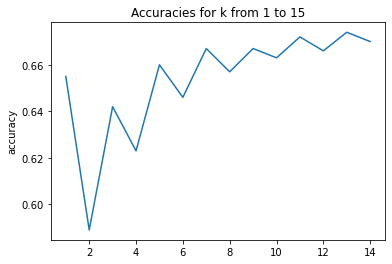

In [56]:
sns.lineplot(x = np.arange(1,15), y = accuracy_lst).set(title = "Accuracies for k from 1 to 15", ylabel = "accuracy");

In [57]:
knn = KNeighborsClassifier(n_neighbors=13, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [58]:
# Append new results to model results
method_result['knn_opt'] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
method_result

,metric,naive bayes,ada_unopt,ada_opt,dec_tree_unopt,dec_tree_opt,knn_opt
0,accuracy,0.65,0.68,0.69,0.66,0.68,0.67
1,f1-score,0.74,0.77,0.77,0.72,0.74,0.75


# Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0)

##### Import Cross Validation - here we set 5

In [60]:
from sklearn.model_selection import cross_val_score
all_F1_score = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5, scoring = "f1")

##### Lets see the single F1-Scores

In [61]:
print(all_F1_score)

[0.75232755 0.7543594  0.75355992 0.75729167 0.75316737]


##### And now the mean of them

In [62]:
print(all_F1_score.mean())

0.7541411821032343


##### The Standard deviation is very small - Thats good

In [63]:
print(all_F1_score.std())

0.0017057904166829475


##### Creating a dictionary of parameters and their corresponding values for our Random Forest

In [64]:
grid_param = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10]
}

##### Creating an instance of the GridSearchCV class with setting values for the estimator parameter. The param_grid parameter takes the parameter dictionary that we just created as parameter, the scoring parameter takes the performance metrics, the cv parameter corresponds to number of folds, which is 5 in our case, and finally the n_jobs parameter refers to the number of CPU's that you want to use for execution. A value of -1 for n_jobs parameter means that use all available computing power, which is handy for a large number amount of data.

In [65]:
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=2,
                     n_jobs=-1)

##### I call now the fit method of the class and pass it to the training and test set. This method can take some time to execute because we have 20 combinations of parameters and a 5-fold cross validation. Therefore the algorithm will execute a total of 100 times.

In [66]:
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='f1')

##### Check the parameters that return the highest accuracy. 

In [67]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 1000}


##### The result shows that the highest F1-Score is achieved when the n_estimators are 1000, max_depth is 10 and criterion is "gini".

##### Finding the F1-Score obtained using the best parameters. Previously we had a mean F1-Score of 75.87% with 100 n_estimators.

In [68]:
best_result = gd_sr.best_score_
print(best_result)

0.7788535901108689


##### The F1-Score achieved is 77.90 % which is only slightly better than 75.87%. Because the highest param-values where the best, we try once again with higher ones

In [69]:
grid_param = {
    'n_estimators': [1600, 2000],
    'max_depth': [12, 14]
}

In [70]:
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=2,
                     n_jobs=-1)

In [71]:
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [12, 14], 'n_estimators': [1600, 2000]},
             scoring='f1')

In [72]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 12, 'n_estimators': 1600}


In [73]:
best_result = gd_sr.best_score_
print(best_result)

0.7787055092625363


##### The F1-Score raised only 0.5 higher than before (77.95% to 77.90%).

##### What about accuracy with these parameters?

In [74]:
all_accuracy_score = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

##### The single accurancy scores

In [75]:
print(all_accuracy_score)

[0.67847107 0.68141653 0.6789112  0.68446355 0.68008532]


##### Their mean

In [76]:
print(all_accuracy_score.mean())

0.6806695337056546


##### ...and the Standard deviation

In [77]:
print(all_accuracy_score.std())

0.0021549427613656324


##### and now our model

In [78]:
grid_param = {
    'n_estimators': [1600, 2000],
    'max_depth': [12, 14]
}

In [79]:
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)

In [80]:
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [12, 14], 'n_estimators': [1600, 2000]},
             scoring='accuracy')

In [81]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 14, 'n_estimators': 2000}


In [82]:
best_result = gd_sr.best_score_
print(best_result)

0.6997643617453482


##### The accuracy-score achieved is 70.19 % which is slightly better than 68.73%.

In [83]:
y_pred = gd_sr.predict(X_test)

In [84]:
# Append new results to model results
method_result['rand_for_opt'] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
method_result

,metric,naive bayes,ada_unopt,ada_opt,dec_tree_unopt,dec_tree_opt,knn_opt,rand_for_opt
0,accuracy,0.65,0.68,0.69,0.66,0.68,0.67,0.70
1,f1-score,0.74,0.77,0.77,0.72,0.74,0.75,0.78


All models seem to be in a range about 60 to 70 % accuracy and 70 to 80 % F1-score. Optimizing the model by hyperparameters didn't show much increase of accuracy. The final best model is random Forest with 70 % accuracy and 78 % F1-score.

# Final Test set

### Import final test set

In [85]:
import glob
path = 'data/final/test/'
all_files = glob.glob(path + '*.csv')
# list to append csvs
l = []
# loop over all files
for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=0)
    l.append(df_tmp)

# Add all data frames together
df_final_test = pd.concat(l, axis=0, ignore_index=True)

### Turn result to dummies

In [86]:
# turn result to dummies
d = {'successful': 1, 'failed': 0}
df_final_test.state = [d[i] for i in df_final_test.state]
y_final = df_final_test.state

### Change category to single feature
Change category dummies to single feature

In [87]:
total = df_final_test.category.value_counts(sort=False)
success = df_final_test.query('state == 1').category.value_counts(sort=False)
category_to_rate = dict(success/total)
df_final_test['category_rate'] = [category_to_rate[i] for i in df_final_test.category]

### Create final set

In [88]:
X_final = df_final_test[['goal_usd', 'word_count', 'days_running', 'category_rate']].copy()

### Scale model

In [89]:
X_final = scaler.transform(X_final)

### Calculate Accuracies with all models

In [90]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_final)
method_result = pd.DataFrame({'metric': ['accuracy', 'f1-score'],
                          'naive bayes': [accuracy_score(y_final, y_pred).round(2), f1_score(y_final, y_pred, pos_label=1).round(2)]})

14279


In [91]:
y_pred = adb.predict(X_final)
method_result['ada_boost'] = [accuracy_score(y_final, y_pred).round(2), f1_score(y_final, y_pred, pos_label=1).round(2)]

13293


In [92]:
y_pred = dtree.predict(X_final)
method_result['decision_tree'] = [accuracy_score(y_final, y_pred).round(2), f1_score(y_final, y_pred, pos_label=1).round(2)]

11807


In [93]:
y_pred = knn.predict(X_final)
method_result['KNN'] = [accuracy_score(y_final, y_pred).round(2), f1_score(y_final, y_pred, pos_label=1).round(2)]

12580


In [94]:
y_pred = gd_sr.predict(X_final)
method_result['random_forest'] = [accuracy_score(y_final, y_pred).round(2), f1_score(y_final, y_pred, pos_label=1).round(2)]

13229


In [95]:
method_result

,metric,naive bayes,ada_boost,decision_tree,KNN,random_forest
0,accuracy,0.67,0.70,0.67,0.67,0.70
1,f1-score,0.76,0.77,0.74,0.75,0.78
